# Lecture 3. Convex optimization problems and how to solve them

## What we have already known

- Convex sets
- Convex functions

## Convex optimization problem

- Informal description: minimization of convex function in the convex set

- Formal form

\begin{align*}
& \min_x f_0(x) \\
\text{s.t. } & Ax = b \\
& f_j(x) \leq 0, \; j = 1,\ldots, m
\end{align*}
where $f_0$ and $f_j$ are convex functions.

## Standard package for solving convex optimization problems

- CVX and its Python version [CVXPy](https://www.cvxpy.org/) are packages based on disciplined convex programming approach
- No freedom in creating objective function and constraints
- Only fixed building blocks and composition rules

<img src="./convex_func_parse.png">

## You can play in quiz about convex function identification

- https://dcp.stanford.edu/home 
- A lot of rules that produce convex functions
- Solver will raise exceptions if you violate the rules

## Applications to be considered today

- Image reconstruction
- Trend filtering in financial data
- Minimum volume covered ellipsoid

In [111]:
import cvxpy as cvx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
print(cvx.installed_solvers())

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'MOSEK', 'OSQP', 'SCS']


## Image reconstruction after pixels losing

- We have colour image
- But some pixels are lost
- We want to reconstruct image such that it will be as close as possible to the original one
- So we need identify
    - Variables 
    - Objective
    - Constraints
- Check convexity and if everythiong is ok, solve it!

In [112]:
from PIL import Image

# np.random.seed(1)
# Load image
orig_img = Image.open("./kandinskiy_comp_viii.jpg")

# Convert to arrays
Uorig = np.array(orig_img)
rows, cols, colors = Uorig.shape
print(Uorig.shape)

# Known is 1 if the pixel is known,
# 0 if the pixel was corrupted
Known = np.zeros((rows, cols, colors))
for i in range(rows):
    for j in range(cols):
        if np.random.random() > 0.7:
            for k in range(colors):
                Known[i, j, k] = 1

# Create corrupted image
Ucorr = Known * Uorig
# Convert to image
corr_img = Image.fromarray(np.uint8(Ucorr))

(425, 640, 3)


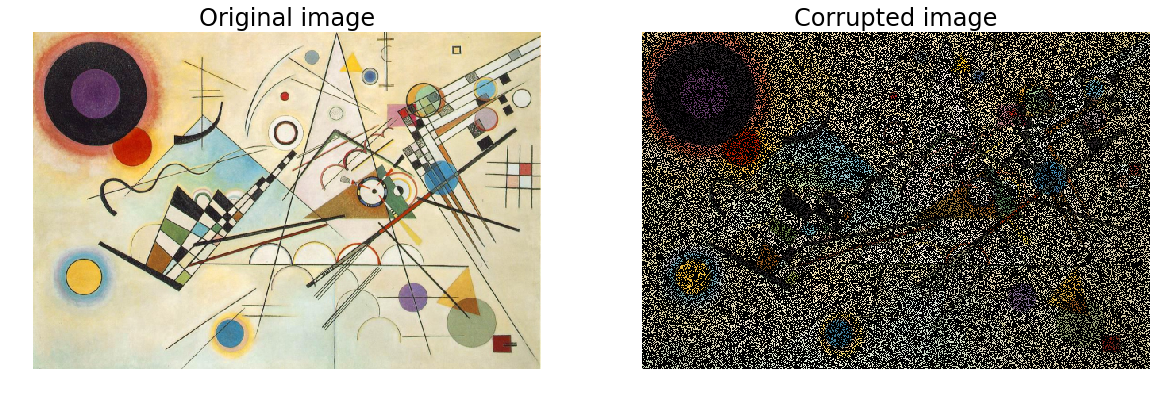

In [113]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(orig_img);
ax[0].set_title("Original image", fontsize=24)
ax[0].axis('off')
ax[1].imshow(corr_img);
ax[1].set_title("Corrupted image", fontsize=24)
ax[1].axis('off');

### Total variation

$$
\begin{align*}
& \min_{X} \sum_{i=1}^{m-1}\sum_{j=1}^{n-1} \left\|\left[ \begin{array}{} 
X_{i+1,j} - X_{ij} \\ X_{i, j+1} - X_{ij}\end{array} \right] \right\|_2\\
\text{s.t. } & X_{ij} = X^{known}_{ij}, \; (i, j) \in \mathcal{I}
\end{align*}
$$

- $\mathcal{I}$ is a set of indices with known values
- Gradient approximation is not squared

In [114]:
# Define variables and constraints
variables = []
constraints = []
for i in range(colors):
#     Slice of image tensor for the i-th color
    U = cvx.Variable(shape=(rows, cols))
#     Append to the list of variables
    variables.append(U)
#     Append constraints: known pixels in the given image 
#     has to be equal to the pixels in reconstructed image
    constraints.append(cvx.multiply(Known[:, :, i], U) == \
                       cvx.multiply(Known[:, :, i], Ucorr[:, :, i]))

In [67]:
# Create minimization problem with created constraints and solve it
prob = cvx.Problem(cvx.Minimize(cvx.tv(*variables)), constraints)
prob.solve(verbose=True, solver="SCS", max_iters=500)

WARN: A->p (column pointers) not strictly increasing, column 542935 empty
WARN: A->p (column pointers) not strictly increasing, column 814935 empty
WARN: A->p (column pointers) not strictly increasing, column 1086935 empty
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 3766755, CG tol ~ 1/iter^(2.00)
eps = 1.00e-04, alpha = 1.50, max_iters = 500, normalize = 1, scale = 1.00
Variables n = 1086936, constraints m = 2712552
Cones:	primal zero / dual free vars: 816000
	soc vars: 1896552, soc blks: 270936
Setup time: 2.64e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     

4609394.084983463

In [68]:
# Load variables values into array
rec_arr = np.zeros((rows, cols, colors), dtype=np.uint8)
for i in range(colors):
    rec_arr[:, :, i] = variables[i].value

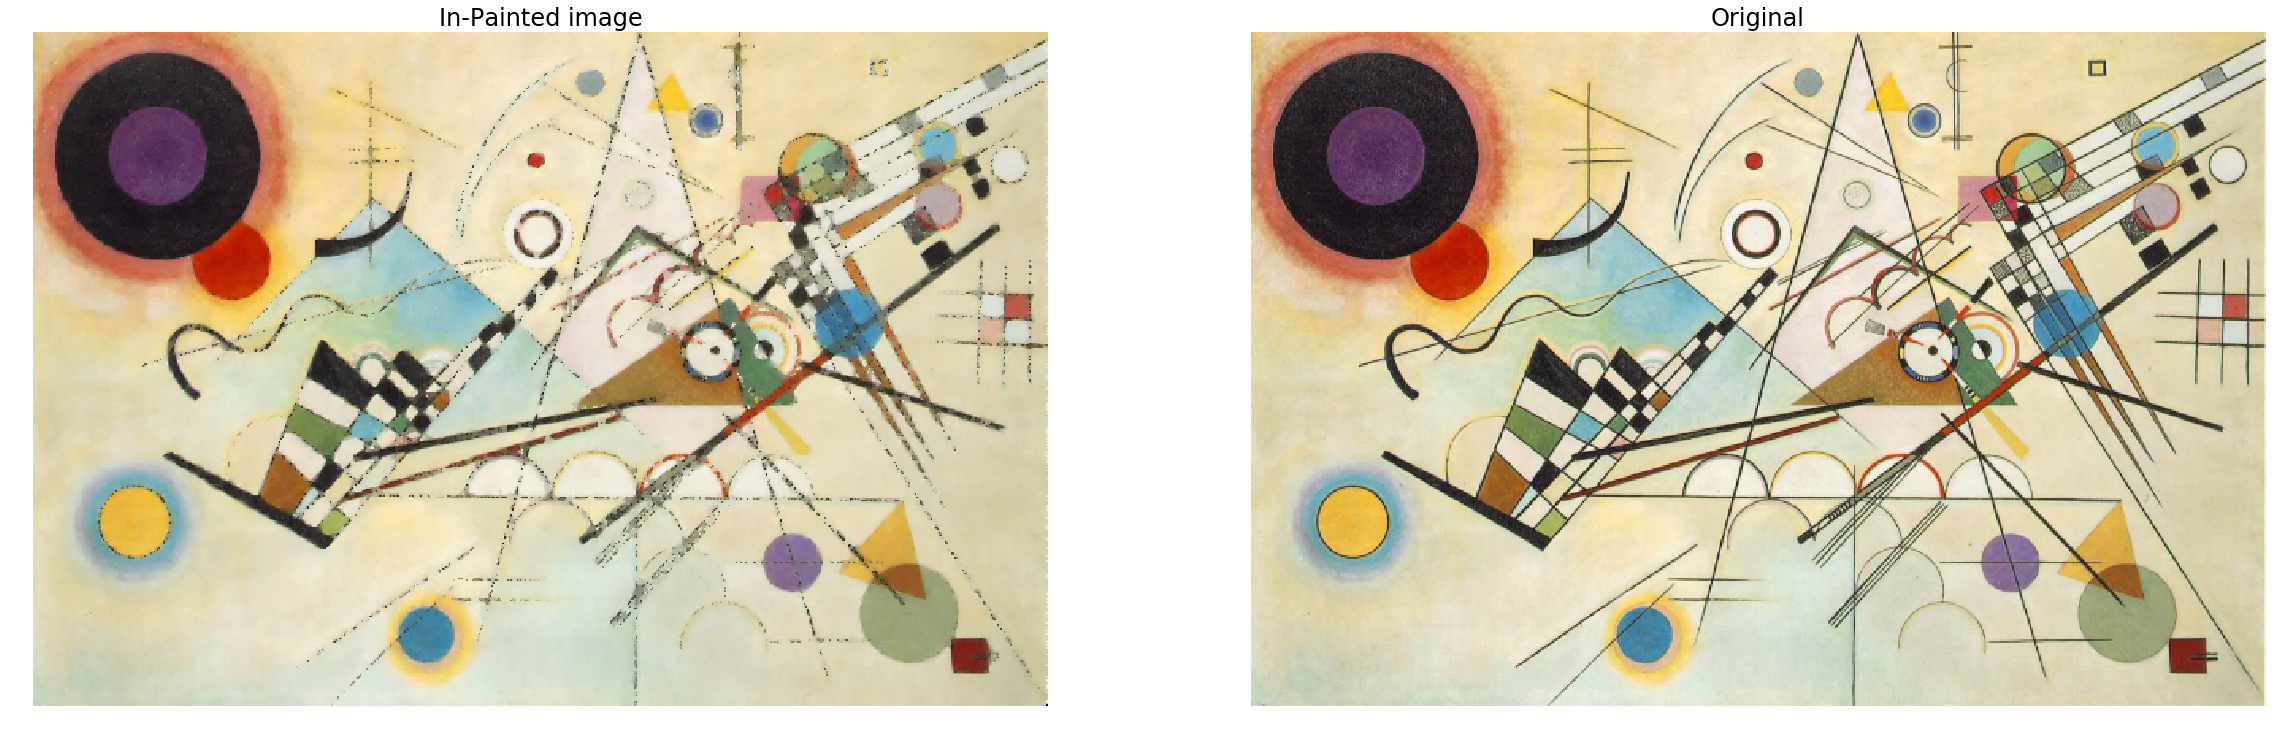

In [120]:
fig, ax = plt.subplots(1, 2, figsize=(40, 50))
img_rec = Image.fromarray(rec_arr)
ax[0].imshow(img_rec);
ax[0].set_title("In-Painted image", fontsize=24)
ax[0].axis('off')

# img_diff = Image.fromarray(np.abs(Uorig - rec_arr))
# ax[1].imshow(img_diff);
# ax[1].set_title("Difference image", fontsize=24)
# ax[1].axis('off');

img_diff = Image.fromarray(Uorig)
ax[1].imshow(img_diff);
ax[1].set_title("Original", fontsize=24)
ax[1].axis('off');

## Summary about this problem

- Colour pictures are 3D tensors
- Missing data can be modeled with the binary mask - it is a linear equality constraint
- Total variation loss is convex function
- Quality of reconstrcution is sufficiently high

## Trend filtering in stock prices

- Given time series with S&P500 index
- We want to smooth or filter it to extract summary on the trend
- How can we do it?

## Problem statement

- Denote by $y$ given data
- We need to find $x$ that simultaneously approximates $y$ and is sufficiently smooth

$$ \min_x \| x - y \|_2 + \lambda \|Dx\|_* $$

- $D$ is a matrix such that $Dx$ approximates second derivative of $x$, i.e. 

$$ D = \begin{bmatrix} 1 & -2 & 1 & \ldots & \ldots \\ 0 & 1 & -2 & 1 & \ldots \\ \ldots & \ldots & \ldots & \ldots & \ldots \end{bmatrix} $$

- We will consider different norms instead of $\| \cdot \|_*$ in the penalization term

In [131]:
data = pd.read_csv("./SANDP-500_2014_2021.txt")
data

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,SANDP-500,D,20141124,0,2063.50,2070.09,2063.50,2069.41,0
1,SANDP-500,D,20141125,0,2069.41,2073.97,2064.82,2067.03,0
2,SANDP-500,D,20141126,0,2067.03,2073.11,2066.70,2072.83,0
3,SANDP-500,D,20141127,0,2072.83,2072.83,2072.83,2072.83,0
4,SANDP-500,D,20141128,0,2072.83,2075.43,2065.15,2067.56,0
...,...,...,...,...,...,...,...,...,...
1758,SANDP-500,D,20211116,0,4679.42,4714.95,4679.42,4700.90,21030
1759,SANDP-500,D,20211117,0,4699.57,4701.19,4684.41,4688.67,21527
1760,SANDP-500,D,20211118,0,4700.72,4708.80,4672.78,4704.54,21733
1761,SANDP-500,D,20211119,0,4708.44,4717.75,4694.22,4697.96,21592


0      2014-11-24
1      2014-11-25
2      2014-11-26
3      2014-11-27
4      2014-11-28
          ...    
1758   2021-11-16
1759   2021-11-17
1760   2021-11-18
1761   2021-11-19
1762   2021-11-22
Name: <DATE>, Length: 1763, dtype: datetime64[ns]

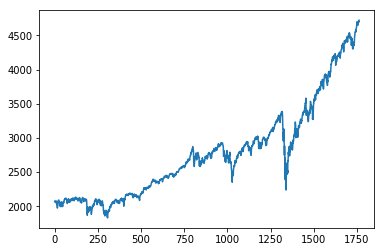

In [132]:
y = data["<CLOSE>"]
plt.plot(y)
time = data["<DATE>"]
time = pd.to_datetime(time.apply(lambda x: str(x)))
time

In [123]:
index_series = pd.DataFrame(np.log(y.values), index=time.values, columns=["S&P500"])
index_series

,S&P500
2014-11-24,7.635019
2014-11-25,7.633868
2014-11-26,7.636670
2014-11-27,7.636670
2014-11-28,7.634124
...,...
2021-11-16,8.455509
2021-11-17,8.452904
2021-11-18,8.456283
2021-11-19,8.454884


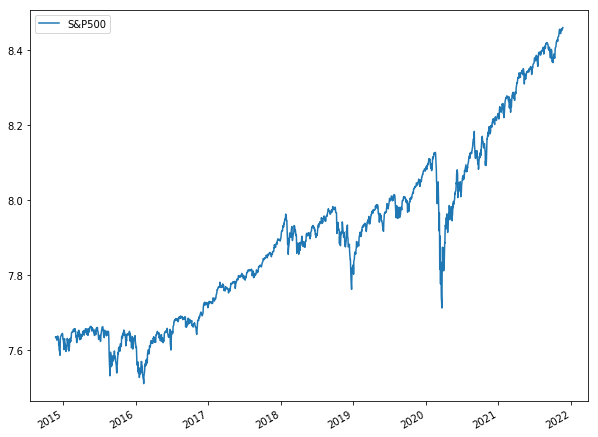

In [133]:
index_series.plot(figsize=(10, 8))

In [143]:
import scipy.sparse
n = y.values.shape[0]

# Form second difference matrix.
e = np.ones((1, n))
D = scipy.sparse.spdiags(np.vstack((e, -2*e, e)), range(3), n-2, n)
print(D.shape)

vlambda = 1000

x = cvx.Variable(shape=n)
obj = cvx.Minimize(0.5 * cvx.sum_squares(index_series.values.ravel() - x)
                    + vlambda * cvx.norm(D * x, 1)
                  )
prob = cvx.Problem(obj)

prob.solve(solver=cvx.CVXOPT, verbose=True)
print('Solver status: {}'.format(prob.status))

(1761, 1763)
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.0000e+00  2e+06  1e-01  2e-03  1e+00
 1:  1.6488e-01  2.6753e-01  2e+05  8e-03  2e-04  3e-01
 2: -1.7876e+00 -4.1478e-01  8e+04  4e-03  9e-05  1e+00
 3: -1.6986e+00 -1.3179e-03  9e+03  4e-04  9e-06  2e+00
 4:  7.9623e-01  9.6986e-01  9e+02  5e-05  9e-07  2e-01
 5:  1.0852e+00  1.2166e+00  6e+02  3e-05  7e-07  1e-01
 6:  1.2047e+00  1.2717e+00  3e+02  1e-05  3e-07  7e-02
 7:  1.4404e+00  1.4854e+00  2e+02  9e-06  2e-07  5e-02
 8:  1.5384e+00  1.5572e+00  7e+01  4e-06  8e-08  2e-02
 9:  1.8220e+00  1.8286e+00  2e+01  1e-06  3e-08  7e-03
10:  1.9282e+00  1.9339e+00  2e+01  1e-06  2e-08  6e-03
11:  2.0551e+00  2.0609e+00  2e+01  1e-06  2e-08  6e-03
12:  2.0326e+00  2.0381e+00  2e+01  1e-06  2e-08  6e-03
13:  2.4396e+00  2.4410e+00  5e+00  2e-07  5e-09  1e-03
14:  2.3651e+00  2.3665e+00  5e+00  3e-07  5e-09  1e-03
15:  2.6295e+00  2.6305e+00  4e+00  2e-07  4e-09  1e-03
16:  2.6066e+00  2.6075e+00  3e+00  1

In [144]:
trend_df = pd.DataFrame(x.value, index=time.values)
res = pd.concat([trend_df, index_series], axis=1)
res.columns = ["trend", "data"]
res

,trend,data
2014-11-24,7.594065,7.635019
2014-11-25,7.594234,7.633868
2014-11-26,7.594403,7.636670
2014-11-27,7.594572,7.636670
2014-11-28,7.594742,7.634124
...,...,...
2021-11-16,8.431654,8.455509
2021-11-17,8.432620,8.452904
2021-11-18,8.433586,8.456283
2021-11-19,8.434553,8.454884


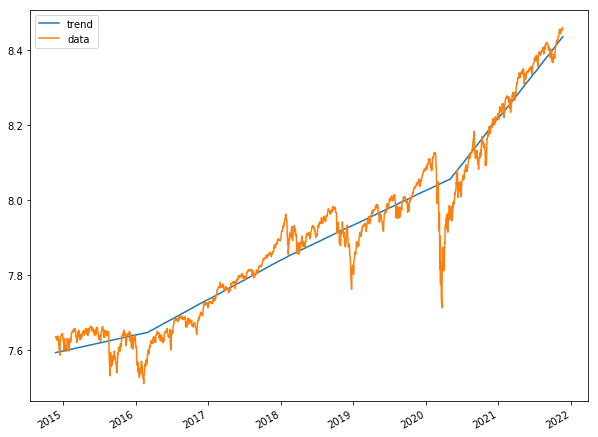

In [145]:
res.plot(figsize=(10, 8))

## Summary of this problem

- Smoothing or filtering of the signal can be modeled with convex optimization
- Most priors for signal reduces to convex functions
- Hyperparameter is important to get the desired property
- CVXPy features in Python syntax

## The L&ouml;wner-John ellipsoid

**Problem**: given a set of points $x_i \in \mathbb{R}^2$, we need to find ellipsoid such that its square is the minimal and all $x_i$ lie inside.

**Parameters**: 

$$
\{x \; | \; \| x \|^2_2 \leq 1\} \to \{ u \;| \; \|u\|^2_2 \leq 1, \; u = Ax + b\}
$$

Then square is factored by $\det (A^{-1})$. 

- determinant is not convex, nor concave function
- $\log\det(A^{-1}) = -\log\det(A)$ - convex function $A \in \mathbb{S}^n_{++}$

### Minimization problem

$$
\begin{align*}
& \min_{A, b} -\log\det(A)\\
\text{s.t. } & \|Ax_i + b\| \leq 1\\
& A \succ 0
\end{align*}
$$

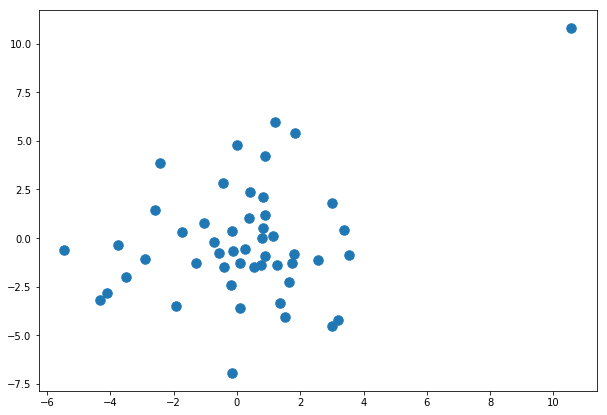

In [155]:
num_points = 50
n = 2
X = 2 * np.random.randn(n, num_points)
X[:, -1] += 10
plt.figure(figsize=(10, 7))
plt.scatter(X[0, :], X[1, :], s=90)

In [156]:
# Create variables: positive semi-definite matrix A and vector b
A = cvx.Variable((n,n))
b = cvx.Variable((n,))
prob = cvx.Problem(cvx.Minimize(-cvx.log_det(A)), 
   [cvx.norm(A * X[:, i] + b) <= 1 for i in range(num_points)] + [A >> 0])

In [157]:
prob.solve(verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 449, CG tol ~ 1/iter^(2.00)
eps = 1.00e-04, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 74, constraints m = 237
Cones:	primal zero / dual free vars: 15
	linear vars: 50
	soc vars: 150, soc blks: 50
	sd vars: 16, sd blks: 3
	exp vars: 6, dual exp vars: 0
Setup time: 7.35e-04s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.05e+00  1.75e+00  9.20e-01 -8.76e+00  2.72e+00  0.00e+00  8.77e-04 
   100| 3.03e-02  5.29e-03  2.18e-03  3.70e+00  3.72e+00  1.50e-15  3.54e-03 
   200| 1.00e-02  7.19e

4.116498506949034

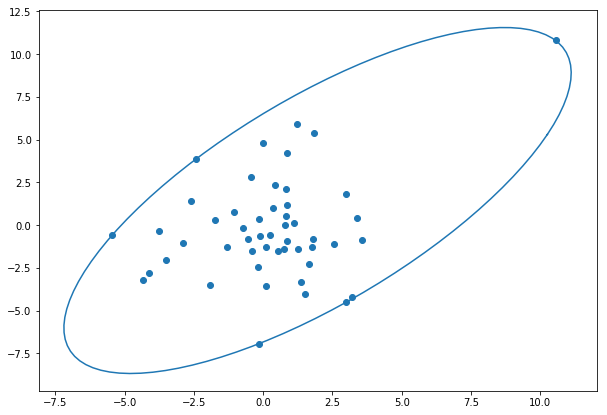

In [158]:
plt.figure(figsize=(10, 7))
plt.scatter(X[0, :], X[1, :])
phi = np.linspace(0, 2 * np.pi, num=100)
xy = np.vstack((np.cos(phi) - b.value[0], np.sin(phi) - b.value[1]))
ellips = np.linalg.solve(A.value, xy)
plt.plot(ellips[0, :], ellips[1, :])

## Summary of this problem

- Positive Semidefinite matrices can be also variables
- CVXPy knows how to deal with such problems
- Standard settings are sparse covariance estimation for distribution identification of the given data
- Robust modification of this problem is interesting extension

## DCP rules and what exceptions arise if one violates some of the rule

In [110]:
x = cvx.Variable(2)
problem = cvx.Problem(cvx.Minimize(cvx.exp(-x[0])),
                      [cvx.quad_over_lin(x[0], x[1]) <= 0])
problem.solve(solver="SCS", eps=1e-7, verbose=True)

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 8, CG tol ~ 1/iter^(2.00)
eps = 1.00e-07, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
Variables n = 4, constraints m = 7
Cones:	linear vars: 1
	soc vars: 3, soc blks: 1
	exp vars: 3, dual exp vars: 0
Setup time: 2.21e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  1.29e-03 
   100| 5.34e-02  7.97e-02  8.84e-02  5.79e-01  7.89e-01  1.12e-16  2.10e-03 
   200| 1.84e-01  5.00e-01  2.68e-01 -3.67e-01 -0.00e+00  0.00e+00  2.47e-03 
   300| 1.90e

In [159]:
# Non-affine equality constraint
y = cvx.Variable(1)
obj = cvx.Minimize(cvx.power(y, 3))
problem = cvx.Problem(obj, [cvx.power(y-3, 2) == 0])
problem.solve(verbose=True)
print(y.value)

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
power(var14613 + -3.0, 2) == 0.0 , because the following subexpressions are not:
|--  power(var14613 + -3.0, 2) == 0.0

In [31]:
# Non-convex objective function 
y = cvx.Variable(2)
obj = cvx.Minimize(y[0]**2 - y[1]**2)
problem = cvx.Problem(obj)
problem.solve(verbose=True)

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
power(var184[0], 2) + -power(var184[1], 2)

## Summary

- CVXPy is a powerful tool for convex optimization
- We will briefly discussed the underlying principles
- Convex optimization problem models a lot of applications
- We will keep discussion in the webinar where more applications and problem settings in CVXPy will be considered